## Getting YSE Image Stamps and Forced Photometry at a Position

IPP can provide forced photometry at any position with YSE data, thanks to a lot of work from Mark and Ken.  The request format is somewhat unintuitive, so this notebook outlines how to make these requests.  Let's use 2021hpr as an example SN with lots of data.  From https://ziggy.ucolick.org/yse/transient_detail/2021smj/ we can get the SN coords

In [8]:
# prelims
import numpy as np
import requests
from astropy.io import fits
import os
import datetime
import numpy as np
from astropy.time import Time
from requests.auth import HTTPBasicAuth
import astropy.table as at
import time
from io import BytesIO
import shutil
from lxml import html
from astropy.coordinates import SkyCoord
import astropy.units as u
import tempfile
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
snid,snra,sndec = '2021smj',186.6939860,8.8826825

To get forced photometry from the IPP, you have to submit a request in FITS format.  For that reason there are some preliminary header format things that I've just dumped below, and we'll see how they get used a little later.

In [3]:
default_stamp_header = fits.Header()
default_stamp_header['XTENSION'] = 'BINTABLE'         
default_stamp_header['BITPIX']  = 8
default_stamp_header['NAXIS']   = 2
default_stamp_header['NAXIS1']  = 476
default_stamp_header['NAXIS2']  = 9
default_stamp_header['PCOUNT']  = 0
default_stamp_header['GCOUNT']  = 1
default_stamp_header['TFIELDS'] = 24
default_stamp_header['TTYPE1']  = 'ROWNUM  '
default_stamp_header['TFORM1']  = 'J       '
default_stamp_header['TTYPE2']  = 'PROJECT '
default_stamp_header['TFORM2']  = '16A     '
default_stamp_header['TTYPE3']  = 'SURVEY_NAME'
default_stamp_header['TFORM3']  = '16A     '
default_stamp_header['TTYPE4']  = 'IPP_RELEASE'
default_stamp_header['TFORM4']  = '16A     '
default_stamp_header['TTYPE5']  = 'JOB_TYPE'
default_stamp_header['TFORM5']  = '16A     '
default_stamp_header['TTYPE6']  = 'OPTION_MASK'
default_stamp_header['TFORM6']  = 'J       '
default_stamp_header['TTYPE7']  = 'REQ_TYPE'
default_stamp_header['TFORM7']  = '16A     '
default_stamp_header['TTYPE8']  = 'IMG_TYPE'
default_stamp_header['TFORM8']  = '16A     '
default_stamp_header['TTYPE9']  = 'ID      '
default_stamp_header['TFORM9']  = '16A     '
default_stamp_header['TTYPE10'] = 'TESS_ID '
default_stamp_header['TFORM10'] = '64A     '
default_stamp_header['TTYPE11'] = 'COMPONENT'
default_stamp_header['TFORM11'] = '64A     '
default_stamp_header['TTYPE12'] = 'COORD_MASK'
default_stamp_header['TFORM12'] = 'J       '
default_stamp_header['TTYPE13'] = 'CENTER_X'
default_stamp_header['TFORM13'] = 'D       '
default_stamp_header['TTYPE14'] = 'CENTER_Y'
default_stamp_header['TFORM14'] = 'D       '
default_stamp_header['TTYPE15'] = 'WIDTH   '
default_stamp_header['TFORM15'] = 'D       '
default_stamp_header['TTYPE16'] = 'HEIGHT  '
default_stamp_header['TFORM16'] = 'D       '
default_stamp_header['TTYPE17'] = 'DATA_GROUP'
default_stamp_header['TFORM17'] = '64A     '
default_stamp_header['TTYPE18'] = 'REQFILT '
default_stamp_header['TFORM18'] = '16A     '
default_stamp_header['TTYPE19'] = 'MJD_MIN '
default_stamp_header['TFORM19'] = 'D       '
default_stamp_header['TTYPE20'] = 'MJD_MAX '
default_stamp_header['TFORM20'] = 'D       '
default_stamp_header['TTYPE21'] = 'RUN_TYPE'
default_stamp_header['TFORM21'] = '16A     '
default_stamp_header['TTYPE22'] = 'FWHM_MIN'
default_stamp_header['TFORM22'] = 'D       '
default_stamp_header['TTYPE23'] = 'FWHM_MAX'
default_stamp_header['TFORM23'] = 'D       '
default_stamp_header['TTYPE24'] = 'COMMENT '
default_stamp_header['TFORM24'] = '64A     '
default_stamp_header['EXTNAME'] = 'PS1_PS_REQUEST'
default_stamp_header['REQ_NAME'] = 'yse.meh_stamp_testid200410'
default_stamp_header['EXTVER']  = '2       '
default_stamp_header['ACTION']  = 'PROCESS '
default_stamp_header['EMAIL']   = 'yse@qub.ac.uk'

default_forcedphot_header = fits.Header()
default_forcedphot_header['XTENSION'] = 'BINTABLE'
default_forcedphot_header['BITPIX']   = 8
default_forcedphot_header['NAXIS']    = 2
default_forcedphot_header['NAXIS1']   = 84
default_forcedphot_header['NAXIS2']   = 8
default_forcedphot_header['PCOUNT']   = 0
default_forcedphot_header['GCOUNT']   = 1
default_forcedphot_header['TFIELDS']  = 9
default_forcedphot_header['TTYPE1']   = 'ROWNUM  '
default_forcedphot_header['TFORM1']   = '20A     '
default_forcedphot_header['TTYPE2']   = 'RA1_DEG '
default_forcedphot_header['TFORM2']   = 'D       '
default_forcedphot_header['TTYPE3']   = 'DEC1_DEG'
default_forcedphot_header['TFORM3']   = 'D       '
default_forcedphot_header['TTYPE4']   = 'RA2_DEG '
default_forcedphot_header['TFORM4']   = 'D       '
default_forcedphot_header['TTYPE5']   = 'DEC2_DEG'
default_forcedphot_header['TFORM5']   = 'D       '
default_forcedphot_header['TTYPE6']   = 'FILTER  '
default_forcedphot_header['TFORM6']   = '20A     '
default_forcedphot_header['TTYPE7']   = 'MJD-OBS '
default_forcedphot_header['TFORM7']   = 'D       '
default_forcedphot_header['TTYPE8']   = 'FPA_ID  '
default_forcedphot_header['TFORM8']   = 'J       '
default_forcedphot_header['TTYPE9']   = 'COMPONENT'
default_forcedphot_header['TFORM9']   = '64A     '
default_forcedphot_header['EXTNAME']  = 'MOPS_DETECTABILITY_QUERY'
default_forcedphot_header['QUERY_ID'] = 'yse.meh_det_test200410'
default_forcedphot_header['EXTVER']   = '2       '
default_forcedphot_header['OBSCODE']  = '566     '
default_forcedphot_header['STAGE']    = 'WSdiff  '
default_forcedphot_header['EMAIL']    = 'yse@qub.ac.uk'


Now we have to figure out which YSE images contain our transient.  Fortunately this info is saved in YSE-PZ, so we just have to query the YSE-PZ API to get details.

In [4]:
my_ysepz_username = ""
my_ysepz_password = ""
ifauser = ""
ifapass = ""
# let's look for anything in the last 30 days
# with field center w/i 1.55 deg of our SN location
min_mjd = Time(datetime.datetime.utcnow()).mjd-30
my_ysepz_url = f"https://ziggy.ucolick.org/yse/api/surveyobservations/?ra_gt={(snra-1.55/np.cos(sndec*np.pi/180.)):.7f}&ra_lt={(snra+1.55/np.cos(sndec*np.pi/180.)):.7f}&dec_gt={sndec-1.55:.7f}&dec_lt={sndec+1.55}&obs_mjd_gte={min_mjd:.3f}"
print(my_ysepz_url)

https://ziggy.ucolick.org/yse/api/surveyobservations/?ra_gt=185.1251705&ra_lt=188.2628015&dec_gt=7.3326825&dec_lt=10.4326825&obs_mjd_gte=59397.863


In [5]:
# now we need the skycell ID for our SN
def getskycell(ra,dec):

    session = requests.Session()
    session.auth = ('ps1sc','skysurveys')
    skycellurl = 'http://pstamp.ipp.ifa.hawaii.edu/findskycell.php'

    # First login. Returns session cookie in response header. Even though status_code=401, it is ok
    page = session.post(skycellurl)

    info = {'ra': (None, ra), 'dec': (None, dec)}
    page = session.post(skycellurl, data=info)

    skycell = page.text.split("<tr><td>RINGS.V3</td><td>skycell.")[-1].split('</td>')[0]
    xpos = page.text.split("<tr><td>RINGS.V3</td><td>skycell.")[-1].split('<td>')[1].split('</td>')[0]
    ypos = page.text.split("<tr><td>RINGS.V3</td><td>skycell.")[-1].split('<td>')[2].split('</td>')[0]

    return skycell,xpos,ypos
skycell = getskycell(snra,sndec)[0]

Let's use the requests module to grab the dataset IDs of the YSE images we care about

In [6]:
# this is sloppy but let's just write a dictionary to translate phot. band IDs on YSE-PZ to filter names
phot_band_dict = {"https://ziggy.ucolick.org/yse/api/photometricbands/36/":"g",
                 "https://ziggy.ucolick.org/yse/api/photometricbands/37/":"r",
                 "https://ziggy.ucolick.org/yse/api/photometricbands/39/":"i",
                 "https://ziggy.ucolick.org/yse/api/photometricbands/40/":"z",
                 "https://ziggy.ucolick.org/yse/api/photometricbands/41/":"y"}

data = requests.get(
    my_ysepz_url,
    auth=HTTPBasicAuth(my_ysepz_username,my_ysepz_password)).json()
    
diff_id_list,warp_id_list,mjd_list,filt_list = [],[],[],[]
for d in data['results']:
    diff_id_list += [d['diff_id']]
    warp_id_list += [d['warp_id']]
    mjd_list += [d['obs_mjd']]
    filt_list += [phot_band_dict[d['photometric_band']]]


Now we can actually request the photometry by putting together an astropy table with the request details and saving to a FITS file.

In [7]:
data = at.Table(names=('ROWNUM','RA1_DEG','DEC1_DEG','RA2_DEG','DEC2_DEG','FILTER','MJD-OBS','FPA_ID','COMPONENT_ID'),
                dtype=('S20','>f8','>f8','>f8','>f8','S20','>f8','>i4','S64'))
for diff_id,mjd,filt,i in zip(diff_id_list,mjd_list,filt_list,range(len(diff_id_list))):
    data.add_row((f'forcedphot_ysebot_{i}',snra,sndec,snra,sndec,filt,mjd,diff_id,'skycell.'+skycell) )

# let's save the request data to a fits file and send to the IPP:
hdr = default_forcedphot_header.copy()
request_name = 'YSE-phot.%s.%s.%i'%(snid,diff_id,time.time())
hdr['QUERY_ID'] = request_name
hdr['EXTNAME'] = 'MOPS_DETECTABILITY_QUERY'
hdr['EXTVER'] = '2'
hdr['OBSCODE'] = '566'
hdr['STAGE'] = 'WSdiff'
ff = fits.BinTableHDU(data, header=hdr)

s = BytesIO()
ff.writeto(s, overwrite=True)


def submit_to_ipp(filename_or_obj):

    session = requests.Session()
    session.auth = (ifauser,ifapass)
    stampurl = 'http://pstamp.ipp.ifa.hawaii.edu/upload.php'
    
    # First login. Returns session cookie in response header. Even though status_code=401, it is ok
    page = session.post(stampurl)

    if type(filename_or_obj) == str: files = {'filename':open(filename,'rb')}
    else: files = {'filename':filename_or_obj.getvalue()}
    page = session.post(stampurl, files=files)

submit_to_ipp(s)


wait a little bit, then check to see if the job is done:

In [11]:
def get_status(request_name):

    status_link = 'http://pstamp.ipp.ifa.hawaii.edu/status.php'
    session = requests.Session()
    session.auth = (ifauser,ifapass)

    page = session.post(status_link)
    page = session.post(status_link)

    if page.status_code == 200:
        lines_out = []
        for line in page.text.split('<pre>')[-1].split('\n'):
            if line and '------------------' not in line and '/pre' not in line:
                lines_out += [line[1:]]
        text = '\n'.join(lines_out)
        tbl = at.Table.read(text,format='ascii',delimiter='|',data_start=1,header_start=0)

        idx = tbl['name'] == request_name
        if not len(tbl[idx]):
            print('warning: could not find request named %s'%request_name)
            return False, False
        if tbl['Completion Time (UTC)'][idx]: done = True
        else: done = False

        if float(tbl['Total Jobs'][idx]) == float(tbl['Successful Jobs'][idx]): success = True
        else:
            success = False
            print('warning: %i of %i jobs failed'%(float(tbl['Total Jobs'][idx])-float(tbl['Successful Jobs'][idx]),float(tbl['Total Jobs'][idx])))

    return done,success
done,success = get_status(request_name)
print(done,success)

False False


once the query is successful, we can grab the photometry.  But, you need to ask mark to allow your IP address to access http://datastore.ipp.ifa.hawaii.edu/pstampresults/.

In [7]:
def get_phot(request_name):
    sct = SkyCoord(snra,sndec,unit=u.deg)
    
    phot_dict = {'mjd':[],'filt':[],'flux':[],'flux_err':[],'dq':[],'stack_id':[],
                 'warp_id':[],'diff_id':[],'ra':[],'dec':[],'exptime':[],'zpt':[]}
    
    phot_link = 'http://datastore.ipp.ifa.hawaii.edu/pstampresults/'
    phot_results_link = '{}/{}/'.format(phot_link,request_name)

    phot_page = requests.get(url=phot_results_link)
    if phot_page.status_code != 200:
        raise RuntimeError('results page {} does not exist'.format(phot_results_link))

    tree = html.fromstring(phot_page.content)
    fitsfiles = tree.xpath('//a/text()')
    for f in fitsfiles:
        if 'detectability' in f:
            phot_fits_link = '{}/{}/{}'.format(phot_link,request_name,f)
            fits_response = requests.get(url=phot_fits_link,stream=True)

            # this is a pain but it seems necessary
            tmpfits = tempfile.NamedTemporaryFile(delete=False)
            shutil.copyfileobj(fits_response.raw, tmpfits)
            tmpfits.close()
            ff = fits.open(tmpfits.name)
            os.remove(tmpfits.name)
            for i in range(len(ff[1].data)):
                mjd = ff[0].header['MJD-OBS']
                exptime = ff[0].header['EXPTIME']
                filt = ff[0].header['FPA.FILTER'].split('.')[0]
                flux = ff[1].data['PSF_INST_FLUX'][i]
                flux_err = ff[1].data['PSF_INST_FLUX_SIG'][i]

                if ff[1].data['PSF_QF'][i] < 0.9 or \
                   (ff[1].data['FLAGS'][i] & 0x00001000) or \
                   (ff[1].data['FLAGS'][i] & 0x20000000) or \
                   (ff[1].data['FLAGS'][i] & 0x40000000) or \
                   (ff[1].data['FLAGS'][i] & 0x80000000) or \
                   (ff[1].data['FLAGS'][i] & 0x00000080) or \
                   (ff[1].data['FLAGS'][i] & 0x00000800): dq = 1
                else: dq = 0
                stack_id = ff[0].header['PPSUB.REFERENCE'].split('.')[-3]
                warp_id = ff[0].header['PPSUB.INPUT'].split('.')[3]
                ra = ff[1].data['RA_PSF'][i]
                dec = ff[1].data['DEC_PSF'][i]
                sc = SkyCoord(ff[1].data['RA_PSF'][i],ff[1].data['DEC_PSF'][i],unit=u.deg)
                sep = sc.separation(sct).arcsec
                if np.min(sep) > 2:
                    raise RuntimeError(
                        'couldn\'t find transient match for RA,Dec=%.7f,%.7f'%(
                        ff[1].data['RA_PSF'][i],ff[1].data['DEC_PSF'][i]))

                phot_dict['mjd'] += [mjd]
                phot_dict['filt'] += [filt]
                phot_dict['flux'] += [flux]
                phot_dict['flux_err'] += [flux_err]
                phot_dict['dq'] += [dq]
                phot_dict['warp_id'] += [warp_id]
                phot_dict['diff_id'] += [f.split('.')[2]]
                phot_dict['ra'] += [ra]
                phot_dict['dec'] += [dec]
                phot_dict['exptime'] += [exptime]
                phot_dict['zpt'] += [ff[0].header['FPA.ZP']]

    return phot_dict

phot_dict = get_phot(request_name)

In [11]:
print(phot_dict['filt'])

['r', 'r', 'r', 'r', 'z', 'i', 'r', 'r', 'z', 'r', 'i', 'r', 'i', 'r', 'z', 'z', 'i', 'g', 'z', 'z', 'r', 'g', 'g', 'r', 'g', 'z', 'r']


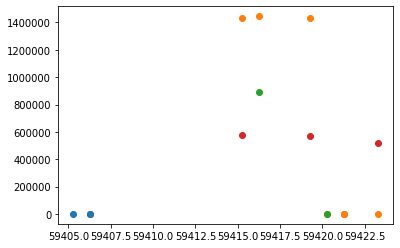

In [12]:
for m,f,flt in zip(phot_dict['mjd'],phot_dict['flux'],phot_dict['filt']):
    if flt == 'g': plt.plot(m,f,'o',color='C0')
    elif flt == 'r': plt.plot(m,f,'o',color='C1')
    elif flt == 'i': plt.plot(m,f,'o',color='C2')
    elif flt == 'z': plt.plot(m,f,'o',color='C3')